# Project 1 Revisited: Importances and Coefficients

# Import Libraries

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5),
                intercept=False, intercept_name="intercept",
                annotate=False, ha='left', va='center', size=12,
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)

        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
            ylabel='Feature Names',
            title=title)
    ax.axvline(0, color='k')


    if annotate == True:
            for bar in ax.patches:
                ## calculate center of bar
                bar_ax = bar.get_y() + bar.get_height() / 2
                ## get the value to annotate
                val = bar.get_width()

                # handle negative values by setting them to position 0
                if val < 0:
                    val_pos = 0
                else:
                    val_pos = val

                # ha and va stand for the horizontal and vertical alignment
                ax.annotate(f"{val:.3f}", (val_pos,bar_ax),
                            ha=ha, va=va, size=size,
                            xytext=xytext, textcoords=textcoords)
    return ax

In [3]:
df = pd.read_csv("Data/sales_predictions_2023.csv")
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


# Clean the Data

In [4]:
# check for object inconsistencies
object_type = df.dtypes[df.dtypes == 'object']
for i in object_type.index:
  print(i, '---')
  print(df[i].unique())
  print("")

Item_Identifier ---
['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']

Item_Fat_Content ---
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']

Item_Type ---
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

Outlet_Identifier ---
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

Outlet_Size ---
['Medium' nan 'High' 'Small']

Outlet_Location_Type ---
['Tier 1' 'Tier 3' 'Tier 2']

Outlet_Type ---
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In [5]:
# fix inconsistencies
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

# Preprocessing

## Define X and y

In [6]:
## Define X and y
target = 'Item_Outlet_Sales'
X = df.drop(columns=target).copy()
y = df[target].copy()
X

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2


In [7]:
## Drop unwanted/inappropriate columns
bad_cols = ['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year']
X = X.drop(columns=bad_cols)
## Perform a train-test-split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [8]:
X_train.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.35,Low Fat,0.029565,Household,256.4646,Medium,Tier 3,Supermarket Type2
7510,15.25,Regular,0.000000,Snack Foods,179.7660,Medium,Tier 3,Supermarket Type2
5828,12.35,Regular,0.158716,Meat,157.2946,Medium,Tier 1,Supermarket Type1


In [9]:
## Make numeric preprocessing pipeline
num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer())])

In [10]:
## Make categorical preprocessing pipeline
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

In [11]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1660f24f0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16611bd30>)])

# Make X_train_df and X_test_df, dataframe verisons of processed X_train/X_test.

In [12]:
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

/Users/huytran_1/anaconda3/envs/dojo-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,pipeline-1__Item_Weight,pipeline-1__Item_Visibility,pipeline-1__Item_MRP,pipeline-2__Item_Fat_Content_Low Fat,pipeline-2__Item_Fat_Content_Regular,pipeline-2__Item_Type_Baking Goods,pipeline-2__Item_Type_Breads,pipeline-2__Item_Type_Breakfast,pipeline-2__Item_Type_Canned,pipeline-2__Item_Type_Dairy,...,pipeline-2__Outlet_Size_MISSING,pipeline-2__Outlet_Size_Medium,pipeline-2__Outlet_Size_Small,pipeline-2__Outlet_Location_Type_Tier 1,pipeline-2__Outlet_Location_Type_Tier 2,pipeline-2__Outlet_Location_Type_Tier 3,pipeline-2__Outlet_Type_Grocery Store,pipeline-2__Outlet_Type_Supermarket Type1,pipeline-2__Outlet_Type_Supermarket Type2,pipeline-2__Outlet_Type_Supermarket Type3
4776,16.350,0.029565,256.4646,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7510,15.250,0.000000,179.7660,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5828,12.350,0.158716,157.2946,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5327,7.975,0.014628,82.3250,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4810,19.350,0.016645,120.9098,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,9.395,0.286345,139.1838,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5191,15.600,0.117575,75.6670,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5390,17.600,0.018944,237.3590,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
860,20.350,0.054363,117.9466,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Get Features Names + Verbose Feature Names Out

In [13]:
## make the preprocessing column transformer WITH CORRECT ARGS!
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

/Users/huytran_1/anaconda3/envs/dojo-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,16.350,0.029565,256.4646,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7510,15.250,0.000000,179.7660,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5828,12.350,0.158716,157.2946,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5327,7.975,0.014628,82.3250,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4810,19.350,0.016645,120.9098,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,9.395,0.286345,139.1838,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5191,15.600,0.117575,75.6670,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5390,17.600,0.018944,237.3590,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
860,20.350,0.054363,117.9466,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Modeling - Linear Regression

In [14]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True):
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train,
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)


    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test,
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)

    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))

    else:
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

In [15]:
from sklearn.linear_model import LinearRegression
lin_reg= LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train,
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.56,847.10,"1,139.58"
Test,0.57,805.66,"1,094.27"


## Extracting and Visualizing Coefficients

In [16]:
## access the .coef_
lin_reg.coef_

array([-1.86061991e+00, -4.25369802e+02,  1.57163724e+01, -3.19165390e+01,
        3.19165390e+01, -1.63590125e+01, -5.07768770e+01,  2.86347174e+01,
        8.68902747e+00, -1.23641286e+02, -1.79124995e+01,  2.58434079e+01,
       -7.89714531e+00,  1.03603584e+01, -1.25886377e+01, -2.84410088e+01,
       -4.56763187e+01,  3.02601914e+02, -3.99522911e+01, -5.79364790e+01,
        2.50521300e+01,  3.92664483e-01, -1.18642156e+02,  1.14937056e+02,
        3.31243566e+00, -7.93529018e+01,  6.77767153e+01,  1.15761865e+01,
       -1.60767755e+03,  2.66230223e+02, -1.83277012e+02,  1.52472434e+03])

In [17]:
## Intercept
lin_reg.intercept_

-76.40011440849821

In [18]:
## Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
coeffs.loc['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                          -1.860620
Item_Visibility                    -425.369802
Item_MRP                             15.716372
Item_Fat_Content_Low Fat            -31.916539
Item_Fat_Content_Regular             31.916539
Item_Type_Baking Goods              -16.359012
Item_Type_Breads                    -50.776877
Item_Type_Breakfast                  28.634717
Item_Type_Canned                      8.689027
Item_Type_Dairy                    -123.641286
Item_Type_Frozen Foods              -17.912499
Item_Type_Fruits and Vegetables      25.843408
Item_Type_Hard Drinks                -7.897145
Item_Type_Health and Hygiene         10.360358
Item_Type_Household                 -12.588638
Item_Type_Meat                      -28.441009
Item_Type_Others                    -45.676319
Item_Type_Seafood                   302.601914
Item_Type_Snack Foods               -39.952291
Item_Type_Soft Drinks               -57.936479
Item_Type_Starchy Foods              25.052130
Outlet_Size_H

In [19]:
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

In [20]:
coeffs = get_coefficients(lin_reg)
coeffs.sort_values()

Outlet_Type_Grocery Store         -1607.677553
Item_Visibility                    -425.369802
Outlet_Type_Supermarket Type2      -183.277012
Item_Type_Dairy                    -123.641286
Outlet_Size_MISSING                -118.642156
Outlet_Location_Type_Tier 1         -79.352902
intercept                           -76.400114
Item_Type_Soft Drinks               -57.936479
Item_Type_Breads                    -50.776877
Item_Type_Others                    -45.676319
Item_Type_Snack Foods               -39.952291
Item_Fat_Content_Low Fat            -31.916539
Item_Type_Meat                      -28.441009
Item_Type_Frozen Foods              -17.912499
Item_Type_Baking Goods              -16.359012
Item_Type_Household                 -12.588638
Item_Type_Hard Drinks                -7.897145
Item_Weight                          -1.860620
Outlet_Size_High                      0.392664
Outlet_Size_Small                     3.312436
Item_Type_Canned                      8.689027
Item_Type_Hea

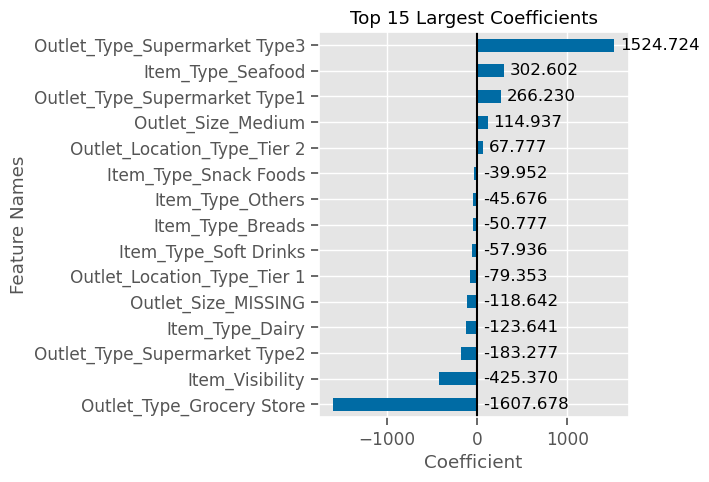

In [21]:
fig, ax = plt.subplots()

plot_coeffs(coeffs, top_n=15, annotate=True);

fig.savefig('Data/top_15_largest_coefficients.png', dpi=70, bbox_inches='tight')

- **Top 3 Most Impactful Features**
    - Outlet_Type_Grocery store
        - If you add one Outlet type grocery store the predicted sales would reduce by 1607.678.
    - Outlet_Type_Supermarket Type3
        - If you add one Outlet_Type_Supermarket Type3 the predicted sales would increase by 1524.724.
    - Item_Visibility
        - If you add one Item_Visibility the predicted sales would decline by 425.370.

# RandomForest Feature Importance

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
evaluate_regression(rf_reg, X_train_df, y_train,
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.94,299.61,431.06
Test,0.55,778.22,"1,119.50"


## Extract and Evaluate Feature Importance

In [24]:
## create a function to extract importances
def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index=rf_reg.feature_names_in_)
    return importances.sort_values()
get_importances(rf_reg)

Item_Type_Others                   0.001611
Item_Type_Seafood                  0.001747
Item_Type_Breads                   0.002537
Outlet_Type_Supermarket Type1      0.002820
Item_Type_Breakfast                0.002885
Item_Type_Hard Drinks              0.002958
Outlet_Type_Supermarket Type2      0.003029
Item_Type_Starchy Foods            0.003344
Item_Type_Meat                     0.003601
Item_Type_Health and Hygiene       0.003818
Outlet_Location_Type_Tier 3        0.004091
Item_Type_Baking Goods             0.004220
Item_Type_Canned                   0.004460
Outlet_Size_High                   0.004900
Outlet_Size_Medium                 0.005192
Item_Fat_Content_Low Fat           0.005197
Item_Fat_Content_Regular           0.005316
Outlet_Size_MISSING                0.005671
Outlet_Location_Type_Tier 2        0.005724
Item_Type_Soft Drinks              0.005738
Item_Type_Frozen Foods             0.005899
Outlet_Location_Type_Tier 1        0.006319
Item_Type_Household             

Text(0.5, 1.0, 'Feature Importances')

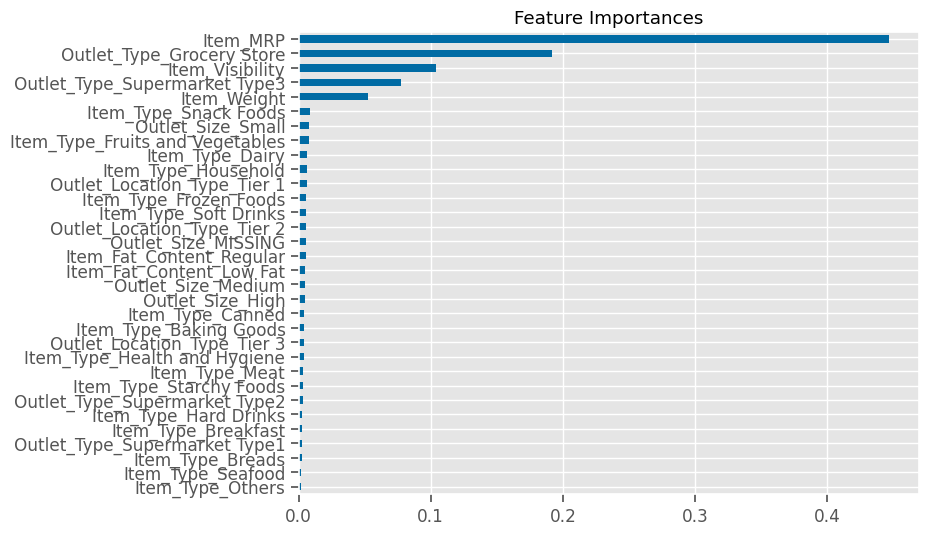

In [26]:
importances = get_importances(rf_reg)
importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title('Feature Importances')


- Top 5 most important features
    - Item MRP
    - Outlet_Type_Grocery Store
    - Item_Visibility
    - Outlet_Type_Supermarket Type3
    - Item_Weight

# Serializing

In [27]:
## saving variables for next lesson/notebook
import joblib
## creating a dictionary of all of the variables to save for later
export = {'X_train_df':X_train_df,
         'y_train_': y_train,
         'X_test_df':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
          'LinearRegression': lin_reg,
         'RandomForest':rf_reg}
joblib.dump(export, 'Data/best_models.joblib')

['Data/best_models.joblib']

In [28]:
loaded = joblib.load('Data/best_models.joblib')
loaded.keys()

dict_keys(['X_train_df', 'y_train_', 'X_test_df', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForest'])